In [30]:
from ThesisPackage.RL.Decentralized_PPO.agent import Agent
from ThesisPackage.Environments.multi_pong_language import PongEnv
from ThesisPackage.Environments.multi_pong_sender_receiver_ball import PongEnvSenderReceiverBall
import torch
import numpy as np
import time
import os

In [31]:
def run_experiment(agent, env, vocab_size, sequence_length, render=False, epochs=50):
    lengths = []
    tokens = {i: {j:0 for j in range(vocab_size)} for i in range(sequence_length)}
    for i in range(50):
        obs, info = env.reset()
        obs = np.array([obs[agent] for agent in env.agents])
        obs = torch.Tensor(obs)
        done = [False]
        while not any(done):
            action, logprob, _, value = agent.get_action_and_value(obs)
            action = action.cpu().numpy()
            utterances = action[0][1:]
            for i, utterance in enumerate(utterances):
                tokens[i][utterance] += 1
            action = {agent: action[i] for i, agent in enumerate(env.agents)}
            if render:
                try:
                    env.render()
                    time.sleep(0.02)
                except IndexError:
                    pass

            obs, rewards, terminated, truncated, info = env.step(action)
            obs = np.array([obs[agent] for agent in env.agents])
            obs = torch.Tensor(obs)
            terminated = [terminated[agent] for agent in env.agents]
            truncated = [truncated[agent] for agent in env.agents]
            if any(truncated) or any(terminated):
                lengths.append(env.timestep)
                done = [True]
                break
    return lengths, tokens

In [32]:
sequence_length = 3
vocab_size = 3

In [33]:
results = []

In [34]:
env = PongEnvSenderReceiverBall(width=20, height=20, sequence_length=sequence_length, vocab_size=vocab_size, max_episode_steps=2048, ball_initialization="opp_random")

agent = Agent(env)
agent.load_state_dict(torch.load('/Users/corneliuswolff/Documents/GitHub/ma.pong_rl/Models/result_3.pt'))
agent.eval()

lengths, tokens = run_experiment(agent, env, vocab_size, sequence_length)
results.append({"Need Communication": False, "Mute":"None", "Length":np.mean(lengths)})

/Users/corneliuswolff/miniconda3/envs/microcosm/lib/python3.10/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [35]:
env = PongEnvSenderReceiverBall(width=20, height=20, sequence_length=sequence_length, vocab_size=vocab_size, max_episode_steps=2048, ball_initialization="uni_random")

lengths, tokens = run_experiment(agent, env, vocab_size, sequence_length)
results.append({"Need Communication": True, "Mute":"None", "Length":np.mean(lengths)})

In [36]:
env = PongEnvSenderReceiverBall(width=20, height=20, self_play=True, receiver="paddle_1", sequence_length=sequence_length, vocab_size=vocab_size, max_episode_steps=2048, ball_initialization="opp_random")

lengths, tokens = run_experiment(agent, env, vocab_size, sequence_length)
results.append({"Need Communication": False, "Mute":"Random", "Length":np.mean(lengths)})

In [37]:
env = PongEnvSenderReceiverBall(width=20, height=20, self_play=True, receiver="paddle_1", sequence_length=sequence_length, vocab_size=vocab_size, max_episode_steps=2048, ball_initialization="uni_random")

lengths, tokens = run_experiment(agent, env, vocab_size, sequence_length)
results.append({"Need Communication": True, "Mute":"Random", "Length":np.mean(lengths)})

In [38]:
env = PongEnvSenderReceiverBall(width=20, height=20, self_play=True, receiver="paddle_1", sequence_length=sequence_length, vocab_size=vocab_size, max_episode_steps=2048, ball_initialization="opp_random", mute_method="zero")

lengths, tokens = run_experiment(agent, env, vocab_size, sequence_length)
results.append({"Need Communication": False, "Mute":"Zero", "Length":np.mean(lengths)})

In [39]:
env = PongEnvSenderReceiverBall(width=20, height=20, self_play=True, receiver="paddle_1", sequence_length=sequence_length, vocab_size=vocab_size, max_episode_steps=2048, ball_initialization="uni_random", mute_method="zero")

lengths, tokens = run_experiment(agent, env, vocab_size, sequence_length)
results.append({"Need Communication": True, "Mute":"Zero", "Length":np.mean(lengths)})

In [40]:
print(results)

[{'Need Communication': False, 'Mute': 'None', 'Length': 2025.3}, {'Need Communication': True, 'Mute': 'None', 'Length': 1244.04}, {'Need Communication': False, 'Mute': 'Random', 'Length': 1902.88}, {'Need Communication': True, 'Mute': 'Random', 'Length': 156.44}, {'Need Communication': False, 'Mute': 'Zero', 'Length': 2047.24}, {'Need Communication': True, 'Mute': 'Zero', 'Length': 798.46}]


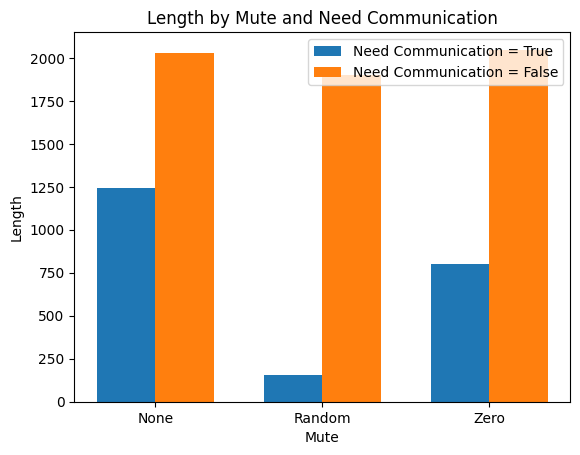

In [44]:
import matplotlib.pyplot as plt

def plot_bar(dictionary_list):
    communication_true = []
    communication_false = []
    labels = ['None', 'Random', 'Zero']

    for item in dictionary_list:
        if item['Need Communication']:
            communication_true.append(item['Length'])
        else:
            communication_false.append(item['Length'])

    x = range(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    bars1 = ax.bar(x, communication_true, width, label='Need Communication = True')
    bars2 = ax.bar([i + width for i in x], communication_false, width, label='Need Communication = False')

    ax.set_xlabel('Mute')
    ax.set_ylabel('Length')
    ax.set_title('Length by Mute and Need Communication')
    ax.set_xticks([i + width / 2 for i in x])
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

plot_bar(results)

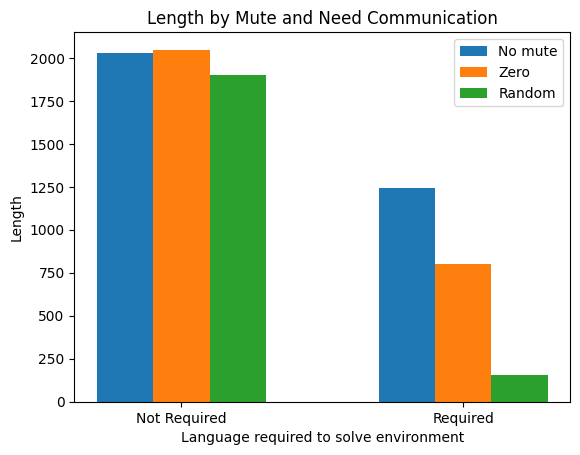

In [48]:
import matplotlib.pyplot as plt

def plot_bar(dictionary_list):
    none = []
    random = []
    zero = []
    labels = ['Not Required', 'Required']

    none = [cur["Length"] for cur in dictionary_list if cur["Mute"] == "None"]
    random = [cur["Length"] for cur in dictionary_list if cur["Mute"] == "Random"]
    zero = [cur["Length"] for cur in dictionary_list if cur["Mute"] == "Zero"]

    x = range(len(labels))
    width = 0.2

    fig, ax = plt.subplots()
    bars1 = ax.bar(x, none, width, label='No mute')
    bars2 = ax.bar([i + width for i in x], zero, width, label='Zero')
    bars3 = ax.bar([i + (width * 2) for i in x], random, width, label='Random')

    ax.set_xlabel('Language required to solve environment')
    ax.set_ylabel('Length')
    ax.set_title('Length by Mute and Need Communication')
    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels(labels)
    ax.legend()

    plt.show()

plot_bar(results)